In [1]:
!pip install scikit-learn
!pip install xgboost
!pip install shap
!pip install wordcloud matplotlib

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import accuracy_score,classification_report
import xgboost as xgb
import shap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import pickle
from wordcloud import WordCloud

In [ ]:
# Replace the file path with the correct path to your CSV file
file_path = "../data/final_dataset_with_stock_price.csv"

# Read the CSV file into a pandas DataFrame
data = pd.read_csv(file_path)

In [ ]:
data.head()

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus=[]
# Get the number of rows in the dataset
num_rows = len(data)
for i in range(0,num_rows):
    headline=re.sub('[^a-zA-Z]',' ', data['headline'][i]) #every punctuation by everything we want (we will replace everything that is not letter to space)
    headline=headline.lower()
    headline=headline.split()
    ps=PorterStemmer()
    all_stopwords=stopwords.words('english')
    all_stopwords.remove('not')
    headline=[ps.stem((word)) for word in headline if not word in set(all_stopwords)]
    headline=' '.join(headline)
    corpus.append(headline)
    
    
# Load a pre-trained sentiment analysis model
sentiment_analyzer = pipeline("sentiment-analysis")

# Define batch size
batch_size = 10000
num_batches = len(corpus) // batch_size + (1 if len(corpus) % batch_size != 0 else 0)

# Process each batch and save the results incrementally
output_file_path = "../data/final_dataset_with_cleaned_and_sentiment.xlsx"
for batch_num in range(num_batches):
    start_idx = batch_num * batch_size
    end_idx = min(start_idx + batch_size, len(corpus))
    batch_corpus = corpus[start_idx:end_idx]

    sentiment_labels = []
    for headline in batch_corpus:
        result = sentiment_analyzer(headline)[0]
        sentiment_labels.append(0 if result['label'] == 'NEGATIVE' else 1)

    # Update the DataFrame with the sentiment labels for the current batch
    data.loc[start_idx:end_idx-1, 'sentiment'] = sentiment_labels

    # Save the DataFrame to an Excel file after each batch
    data.to_excel(output_file_path, index=False)

    print(f"Processed batch {batch_num+1} of {num_batches} and saved to {output_file_path}")

print("Batch processing complete. Final results saved.")

In [5]:
# Replace the file path with the correct path to your CSV file
file_path = "../data/final_dataset_with_cleaned_and_sentiment.xlsx"

# Read the CSV file into a pandas DataFrame
data = pd.read_excel(file_path)

In [6]:
data.head()

date                                           headline        Open  \
0  3/20/2018  Jim Cramer : A better way to invest in the Cov...  244.465456   
1  3/20/2018    Cramer's lightning round : I would own Teradyne  244.465456   
2  3/20/2018  Cramer's week ahead : Big week for earnings , ...  244.465456   
3  3/20/2018  IQ Capital CEO Keith Bliss says tech and healt...  244.465456   
4  3/20/2018  Wall Street delivered the 'kind of pullback I'...  244.465456   

        Close  Difference (%)  \
0  244.474487        0.003694   
1  244.474487        0.003694   
2  244.474487        0.003694   
3  244.474487        0.003694   
4  244.474487        0.003694   

                                    cleaned_headline  sentiment  
0  jim cramer better way invest covid vaccin gold...        0.0  
1                  cramer lightn round would teradyn        0.0  
2  cramer week ahead big week earn even bigger we...        1.0  
3  iq capit ceo keith bliss say tech healthcar ralli        0.0  
4  wall street deliv kind pullback wait jim crame...        0.0

In [9]:
clean_data=data[['cleaned_headline','Open','Close']].copy()

In [11]:
clean_data

cleaned_headline        Open  \
0        jim cramer better way invest covid vaccin gold...  244.465456   
1                        cramer lightn round would teradyn  244.465456   
2        cramer week ahead big week earn even bigger we...  244.465456   
3        iq capit ceo keith bliss say tech healthcar ralli  244.465456   
4        wall street deliv kind pullback wait jim crame...  244.465456   
...                                                    ...         ...   
1048570           ba suspend gatwick flight due coronaviru  240.161607   
1048571  councillor oven readi scheme forc privat schoo...  240.161622   
1048572  councillor oven readi scheme forc privat schoo...  240.161607   
1048573  councillor oven readi scheme forc privat schoo...  240.161638   
1048574  councillor oven readi scheme forc privat schoo...  240.161591   

              Close  
0        244.474487  
1        244.474487  
2        244.474487  
3        244.474487  
4        244.474487  
...             ...  
1048570  235.135864  
1048571  235.135879  
1048572  235.135864  
1048573  235.135895  
1048574  235.135849  

[1048575 rows x 3 columns]

In [13]:
clean_data = clean_data.dropna(subset=['Open'])
print(clean_data.count())

cleaned_headline    941915
Open                941915
Close               941915
dtype: int64


In [15]:
clean_data = clean_data.copy()
clean_data['Movement'] = (clean_data['Close'] > clean_data['Open']).astype(int)


In [17]:
# Prepare features and target
X_text = clean_data[['cleaned_headline']]
X_open = clean_data[['Open']]
y = clean_data['Movement']

In [19]:
X_text['cleaned_headline']

0          jim cramer better way invest covid vaccin gold...
1                          cramer lightn round would teradyn
2          cramer week ahead big week earn even bigger we...
3          iq capit ceo keith bliss say tech healthcar ralli
4          wall street deliv kind pullback wait jim crame...
                                 ...                        
1048570             ba suspend gatwick flight due coronaviru
1048571    councillor oven readi scheme forc privat schoo...
1048572    councillor oven readi scheme forc privat schoo...
1048573    councillor oven readi scheme forc privat schoo...
1048574    councillor oven readi scheme forc privat schoo...
Name: cleaned_headline, Length: 941915, dtype: object

In [21]:

X_train_text, X_test_text,X_open_train,X_open_test, y_train, y_test = train_test_split(X_text,X_open, y, test_size=0.2, random_state=42)


In [23]:
X_open_train[['Open']]

Open
521592  238.357070
347384  238.357070
524411  238.357038
149966  244.429371
802906  236.516373
...            ...
259178  241.731570
365838  238.357007
131932  244.429371
777815  236.516343
121958  244.429371

[753532 rows x 1 columns]

In [25]:

# Initialize StandardScaler for Open prices
scaler = StandardScaler()
X_open_train_scaled = scaler.fit_transform(X_open_train)
X_open_test_scaled = scaler.transform(X_open_test)


In [27]:
X_open_test_scaled

array([[-0.93937483],
       [ 1.7292158 ],
       [ 1.7292158 ],
       ...,
       [ 0.8194107 ],
       [ 1.72923124],
       [-0.93935958]])

In [29]:
vectorizer = TfidfVectorizer(max_features=1000)

# get tf-df values
X_train_text_tfidf = vectorizer .fit_transform(X_train_text['cleaned_headline']) 
X_test_text_tfidf = vectorizer.transform(X_test_text['cleaned_headline'])

In [30]:

# Convert the matrix to a dense array and print
print(X_train_text_tfidf.toarray())

# Get feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()
print(feature_names)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['account' 'accus' 'act' 'action' 'activ' 'activist' 'ad' 'add'
 'administr' 'advertis' 'advis' 'affect' 'age' 'agenc' 'agenda' 'agre'
 'agreement' 'ahead' 'aid' 'aim' 'air' 'airbu' 'aircraft' 'airlin'
 'airport' 'airway' 'alibaba' 'alleg' 'allianc' 'allow' 'almost'
 'alphabet' 'amazon' 'america' 'american' 'amid' 'among' 'analyst'
 'announc' 'annual' 'anoth' 'anti' 'antitrust' 'app' 'appeal' 'appl'
 'appoint' 'approv' 'april' 'arabia' 'aramco' 'around' 'arrest' 'asda'
 'asia' 'ask' 'asset' 'attack' 'australia' 'australian' 'auto' 'automak'
 'aviat' 'avoid' 'away' 'back' 'bad' 'bailout' 'ban' 'bank' 'banker'
 'bankruptci' 'barclay' 'base' 'batteri' 'battl' 'bayer' 'bear' 'beat'
 'becom' 'begin' 'behind' 'benefit' 'best' 'bet' 'better' 'beyond' 'bid'
 'big' 'biggest' 'bill' 'billion' 'billionair' 'bitcoin' 'bite' 'black'
 'blackrock'

In [33]:

# Train XGBoost for numerical features
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1,
    alpha=1,   
    # L1 regularization term on weights
    )  # L2 regularization term on weights
xgb_model.fit(X_open_train_scaled, y_train)


XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [35]:
# Train Logistic Regression for text data
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_text_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [37]:
# Predict on test data
y_pred_text = log_reg.predict(X_test_text_tfidf)
y_pred_open = xgb_model.predict(X_open_test_scaled)

In [39]:
print(y_pred_text)
print(y_pred_open)



[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 1]


In [41]:
# Evaluate Logistic Regression
print(f'Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_text)}')

# Evaluate XGBoost
print(f'XGBoost Accuracy: {accuracy_score(y_test, y_pred_open)}')

Logistic Regression Accuracy: 0.5462913320204053
XGBoost Accuracy: 1.0


In [43]:
# Combining the predictions
# Here we are simply averaging the probabilities for illustration
# You can use more sophisticated methods like stacking for combining
def combine_predictions(pred_text, pred_open):
    # Average predictions for demonstration
    return (pred_text + pred_open) / 2


In [45]:
# For binary classification, you might want to convert average predictions to class labels
def final_prediction(pred_prob):
    return np.round(pred_prob)

In [47]:
# Combine predictions and evaluate
combined_preds = combine_predictions(y_pred_text, y_pred_open)
final_preds = final_prediction(combined_preds)

print(f'Combined Model Accuracy: {accuracy_score(y_test, final_preds)}')



Combined Model Accuracy: 0.5464399653896583


In [49]:

print(combined_preds)
print(y_pred_text)
print(y_pred_open)
print(final_preds)

[0.5 0.  0.  ... 0.  0.  0.5]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 1]
[0. 0. 0. ... 0. 0. 0.]


<Figure size 1000x800 with 0 Axes>

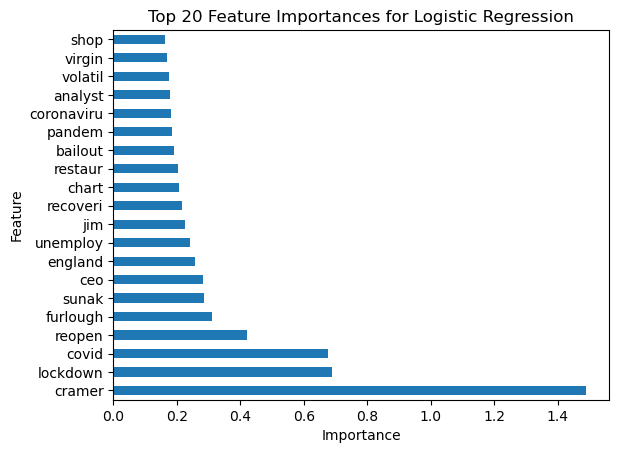

In [51]:

# Feature Importance for Logistic Regression
coefficients = log_reg.coef_.flatten()
importance = np.abs(coefficients)
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance for Logistic Regression
plt.figure(figsize=(10, 8))
importance_df.head(20).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title('Top 20 Feature Importances for Logistic Regression')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()



In [239]:
#result=""
#result= result.join(X_text['cleaned_headline'])

In [241]:
# Generate the word cloud
#wordcloud = WordCloud(width=800, height=400, background_color='white').generate(result)

# Display the word cloud
#plt.figure(figsize=(10, 5))
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis('off')
#plt.show()


In [243]:
#from collections import Counter
#import matplotlib.pyplot as plt  # Missing import
#import seaborn as sns


# Tokenize the text into words
#words =result.lower().split()

# Count the frequency of each word
#word_freq = Counter(words)

# Get the most common words (you can adjust the number)
#most_common_words = word_freq.most_common(20)

# Convert to separate lists for plotting
#words, counts = zip(*most_common_words)

# Plot the bar chart
#plt.figure(figsize=(10, 6))
#sns.barplot(x=list(counts), y=list(words), palette='viridis')  # Ensure the inputs are lists
#plt.xlabel('Frequency')
#plt.ylabel('Words')
#plt.title('Top 20 Most Common Words')  # Updated title to reflect top 20 words
#plt.show()


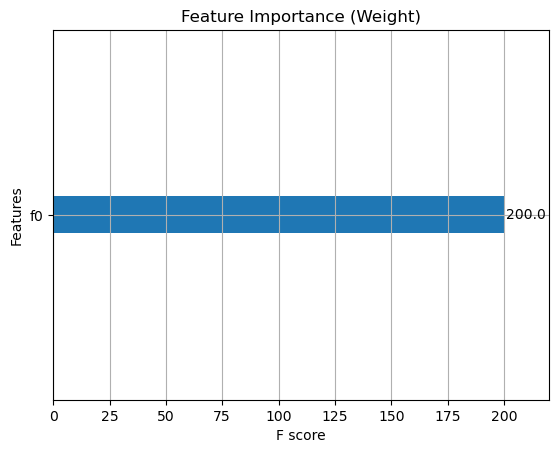

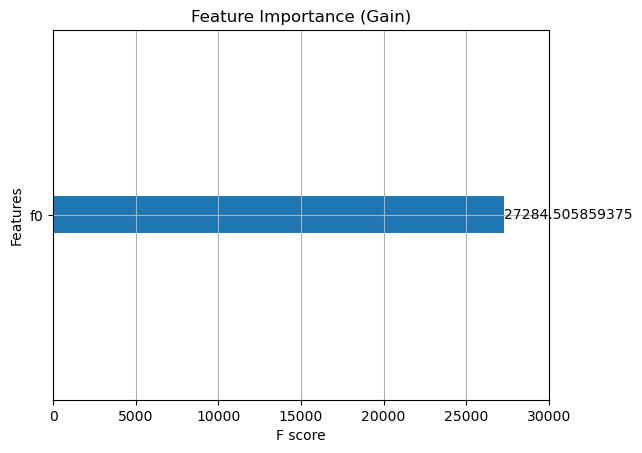

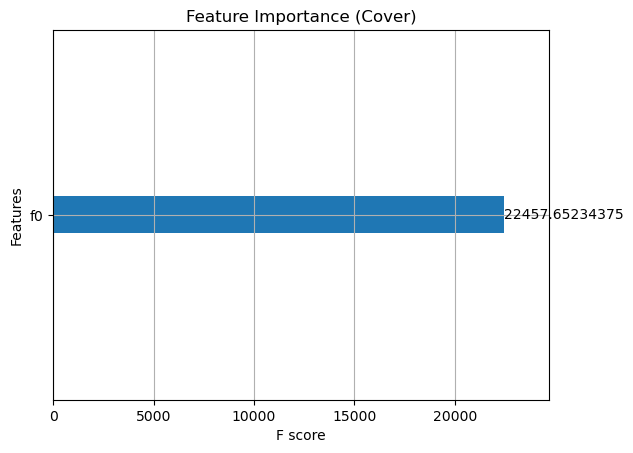

In [245]:
# Plot feature importance
xgb.plot_importance(xgb_model, importance_type='weight', title='Feature Importance (Weight)')
plt.show()

xgb.plot_importance(xgb_model, importance_type='gain', title='Feature Importance (Gain)')
plt.show()

xgb.plot_importance(xgb_model, importance_type='cover', title='Feature Importance (Cover)')
plt.show()

In [247]:
# Create a SHAP explainer
explainer_xgb = shap.TreeExplainer(xgb_model, X_open_train_scaled)

In [251]:
shap_values_xgb = explainer_xgb(X_open_test_scaled)


 98%|===================| 184750/188383 [00:49<00:00]        

In [253]:
shap_values_xgb

.values =
array([[  9.48249948],
       [-11.55821391],
       [-11.55821391],
       ...,
       [-11.55821391],
       [-11.55821391],
       [  9.48249948]])

.base_values =
array([0.93509486, 0.93509486, 0.93509486, ..., 0.93509486, 0.93509486,
       0.93509486])

.data =
array([[-0.93937483],
       [ 1.7292158 ],
       [ 1.7292158 ],
       ...,
       [ 0.8194107 ],
       [ 1.72923124],
       [-0.93935958]])

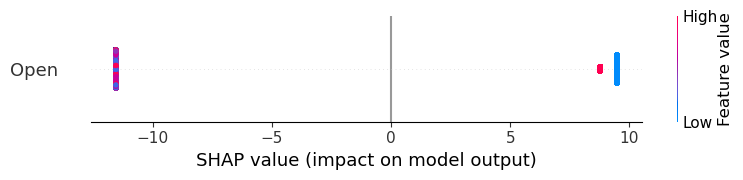

In [255]:
shap.summary_plot(shap_values_xgb, X_open_test_scaled, feature_names=['Open'])


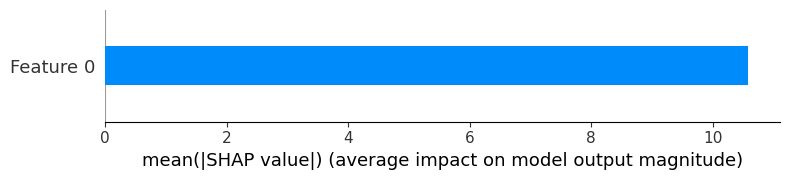

In [257]:
shap.summary_plot(shap_values_xgb, X_open_test_scaled, plot_type='bar')


In [259]:
explainer_xgb.expected_value

0.9350948567060726

In [261]:
shap.initjs()

# Compute SHAP values for a specific instance (e.g., the first instance in the test set)

shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[10].values, X_open_test_scaled[10])


In [263]:
# Logistic Regression feature importance
log_reg_coeffs = log_reg.coef_[0]
features = vectorizer.get_feature_names_out()

# Create DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': np.abs(log_reg_coeffs)
}).sort_values(by='Importance', ascending=False)

print(importance_df)

      Feature  Importance
203    cramer    1.487796
518  lockdown    0.687091
202     covid    0.675734
723    reopen    0.421685
371  furlough    0.309023
..        ...         ...
471    justic    0.000387
532      made    0.000386
33    america    0.000201
656     pound    0.000115
209     crude    0.000015

[1000 rows x 2 columns]


In [265]:
# Summarize the background data using K-means clustering
#background_data = shap.kmeans(X_train_text_tfidf, 100)  # Summarize into 100 clusters

#background_data = shap.sample(X_train_text_tfidf, 100)  # Sample 100 instances
# Create the explainer with the summarized background data
#explainer_log = shap.KernelExplainer(log_reg.predict_proba, background_data)  # Adjust if using LinearExplainer


# Summarize the background data using K-means clustering
n_clusters = 100
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(X_train_text_tfidf)
cluster_indices = kmeans.predict(X_train_text_tfidf)
background_data = kmeans.cluster_centers_

In [266]:
# Create the explainer with the summarized background data
explainer_log = shap.LinearExplainer(log_reg, background_data, feature_perturbation="interventional")


C:\Anaconda\Lib\site-packages\shap\explainers\_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [267]:

# Compute SHAP values for the first 100 samples of the test data
shap_values_log = explainer_log.shap_values(shap.sample(X_test_text_tfidf, 100))


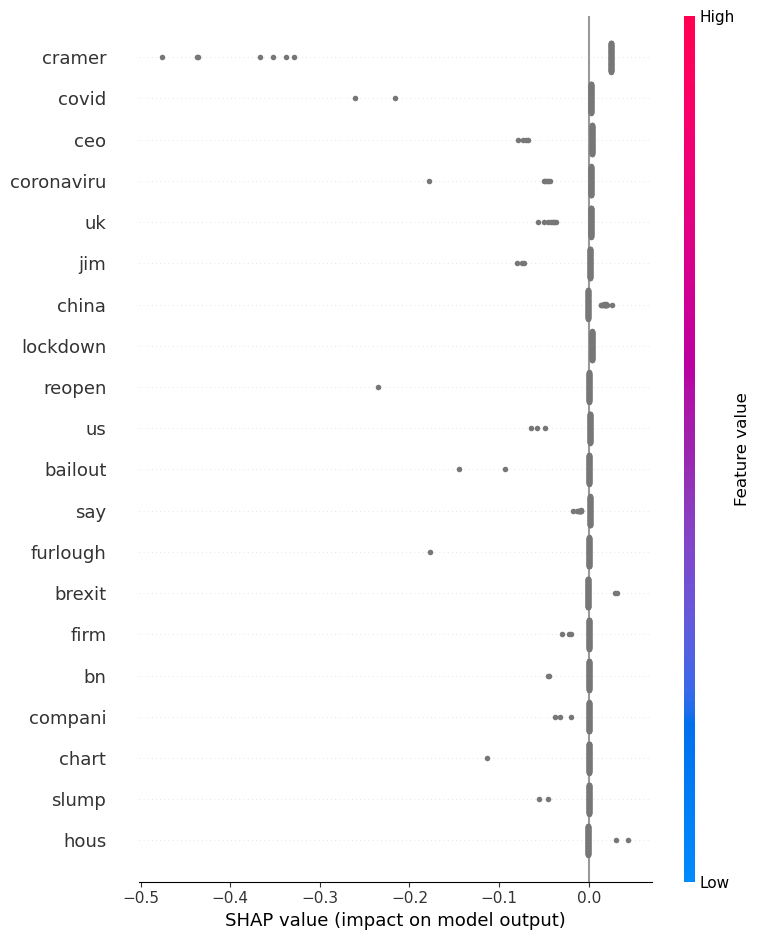

In [271]:

# Plot the summary of SHAP values
shap.summary_plot(shap_values_log, shap.sample(X_test_text_tfidf, 100), feature_names=vectorizer.get_feature_names_out())


In [273]:
shap_values_log

array([[-5.36628031e-06, -5.42083507e-05,  3.94683472e-05, ...,
        -5.73825900e-05, -7.25466682e-06, -5.70320393e-05],
       [-5.36628031e-06, -5.42083507e-05,  3.94683472e-05, ...,
        -5.73825900e-05, -7.25466682e-06, -5.70320393e-05],
       [-5.36628031e-06, -5.42083507e-05,  3.94683472e-05, ...,
        -5.73825900e-05, -7.25466682e-06, -5.70320393e-05],
       ...,
       [-5.36628031e-06, -5.42083507e-05,  3.94683472e-05, ...,
        -5.73825900e-05, -7.25466682e-06, -5.70320393e-05],
       [-5.36628031e-06, -5.42083507e-05,  3.94683472e-05, ...,
        -5.73825900e-05, -7.25466682e-06, -5.70320393e-05],
       [-5.36628031e-06, -5.42083507e-05,  3.94683472e-05, ...,
        -5.73825900e-05, -7.25466682e-06, -5.70320393e-05]])

In [275]:
test_data=shap.sample(X_test_text_tfidf, 100)
# Compute SHAP values for a specific instance (e.g., first instance in test data)
instance_index = 0
shap_values_instance = explainer_log.shap_values(test_data[instance_index].toarray())

# Draw the SHAP force plot for the instance
shap.force_plot(explainer_log.expected_value, shap_values_instance, test_data[instance_index].toarray(), feature_names=vectorizer.get_feature_names_out())


In [291]:
# Save the XGBoost model
with open('salma_xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)


In [281]:

# Save the Logistic Regression model
with open('salma_log_reg.pkl', 'wb') as file:
    pickle.dump(log_reg, file)

In [295]:
# Save the vectorizer
with open('salma_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

In [5]:

# save_functions.py
from salma_functions import clean_text, collect_headlines, fetch_spy_data

def save_functions(functions, filename):
    with open(filename, 'wb') as file:
        pickle.dump(functions, file)

functions_dict = {
    'clean_text': clean_text,
    'collect_headlines': collect_headlines,
    'fetch_spy_data': fetch_spy_data
}

save_functions(functions_dict, 'salma_functions.pkl')
# save_functions.py

from salma_functions import clean_text, collect_headlines, fetch_spy_data

def save_functions(functions, filename):
    with open(filename, 'wb') as file:
        pickle.dump(functions, file)

functions_dict = {
    'clean_text': clean_text,
    'collect_headlines': collect_headlines,
    'fetch_spy_data': fetch_spy_data
}

save_functions(functions_dict, 'salma_functions.pkl')